In [19]:
%reload_ext autoreload
%autoreload 2

In [20]:
import exploring_script as es
import importlib
importlib.reload(es)
import pandas as pd
import swifter
import numpy as np

In [21]:
from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=True,
)

In [22]:
confirmed_sso = es.load_data(columns=["ssnamenr", "ra", "dec", "jd", "nid"])

In [23]:
prep_speed_gb = confirmed_sso.sort_values("jd").groupby("ssnamenr").agg(list)

In [24]:
speed_sso = prep_speed_gb.swifter.apply(es.sep_df, axis=1)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [7]:
speed_sso = speed_sso.explode().replace([np.inf], np.nan).dropna().reset_index(drop=True)

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


### Solar System Object Speed Distribution

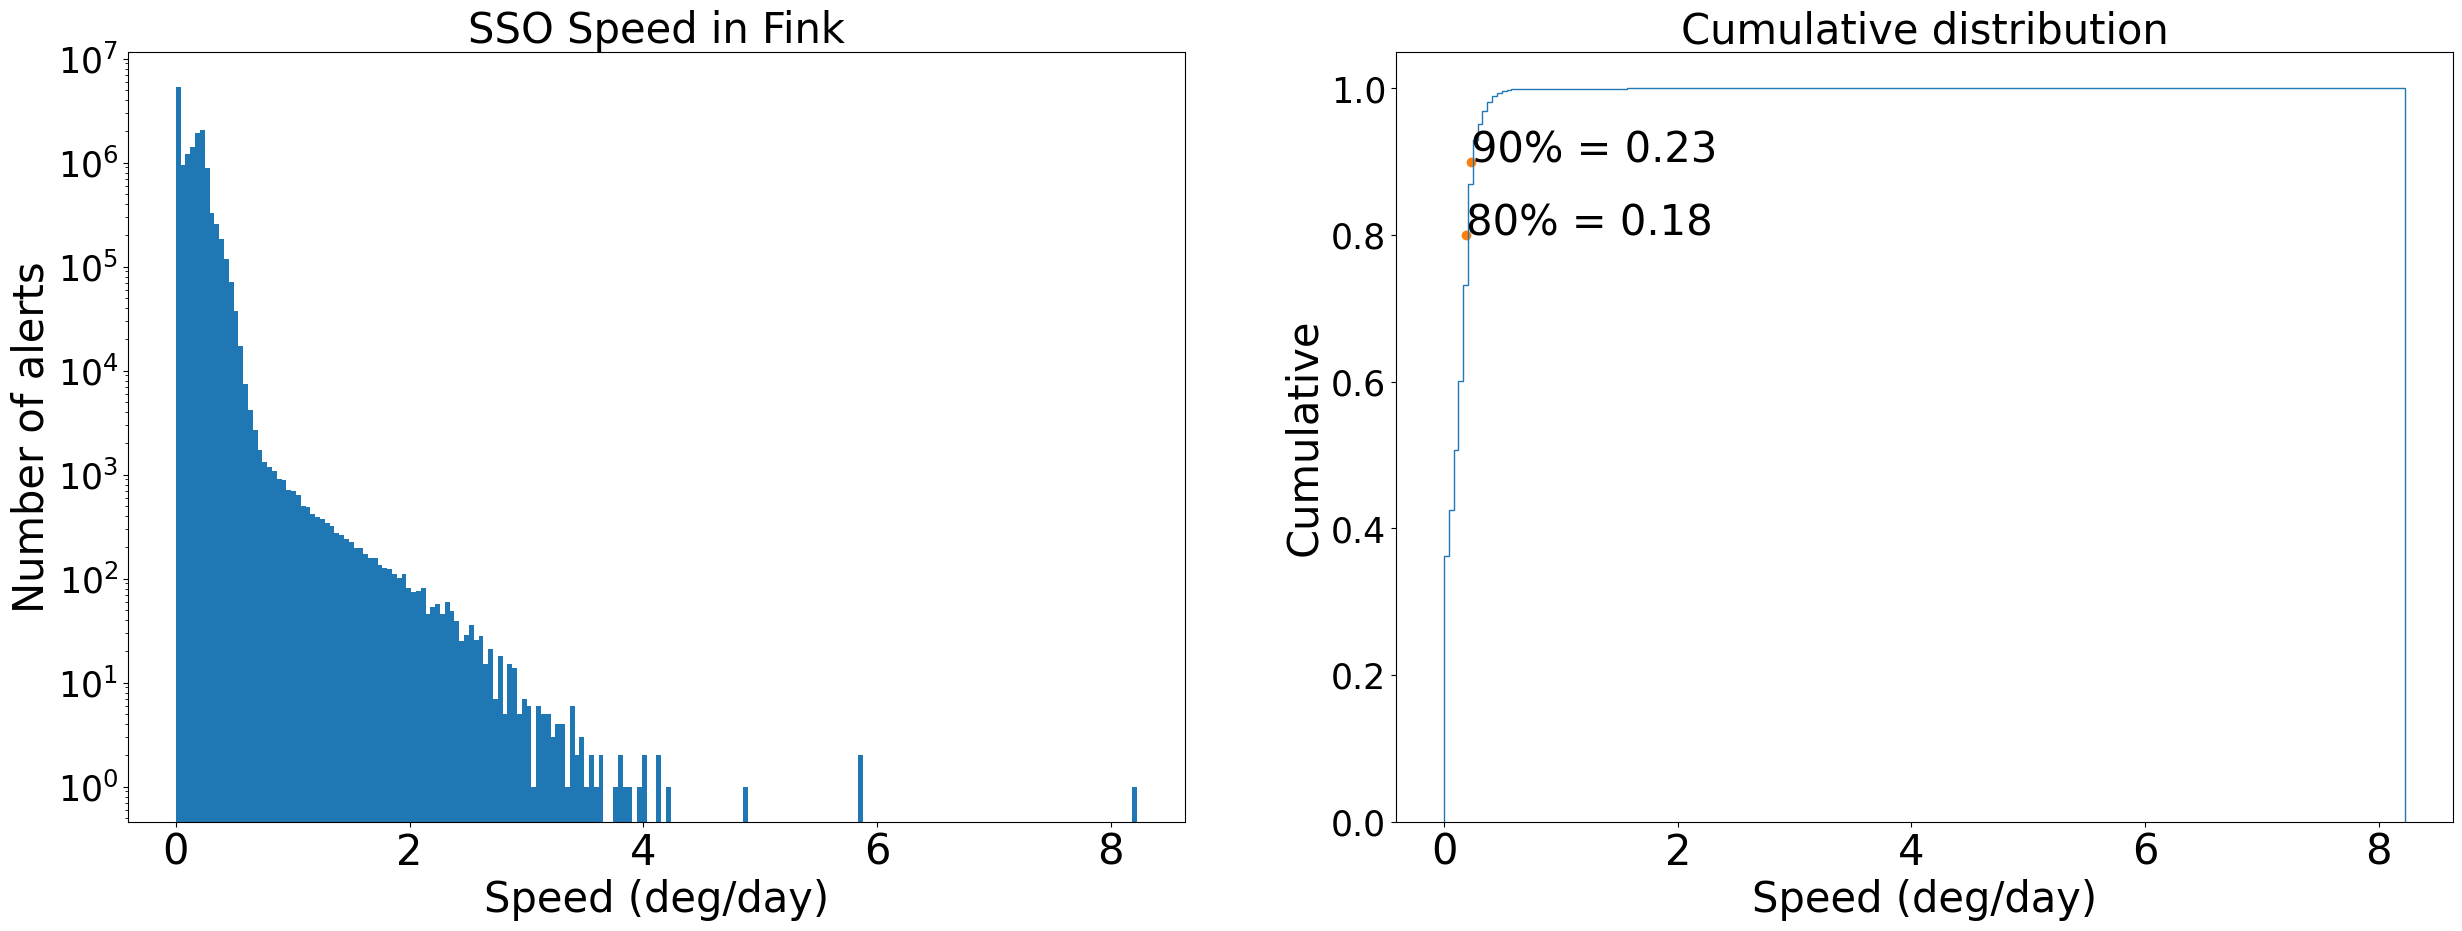

In [8]:
import matplotlib.pyplot as plt
es.plot_hist_and_cdf(speed_sso, None, "SSO Speed in Fink", "Speed (deg/day)", "Number of alerts", None, "Cumulative distribution", "Speed (deg/day)", "Cumulative")

### Solar System Object Intra-night separation

In [49]:
prep_sep_gb = confirmed_sso.sort_values("jd").groupby(["nid", "ssnamenr"]).agg(
    ra=("ra", list),
    dec=("dec", list),
    jd=("jd", list),
    nb_obs=("ra", len)
)

In [50]:
prep_sep = prep_sep_gb[prep_sep_gb["nb_obs"] > 1].reset_index()

In [58]:
prep_sep_limit = prep_sep.sample(int(3e5), random_state=1)

In [59]:
intra_night_sep = prep_sep_limit.swifter.apply(es.intra_sep_df, axis=1)

Pandas Apply:   0%|          | 0/300000 [00:00<?, ?it/s]

In [60]:
speed_intra_sso = intra_night_sep.explode().replace([np.inf], np.nan).dropna().reset_index(drop=True)

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


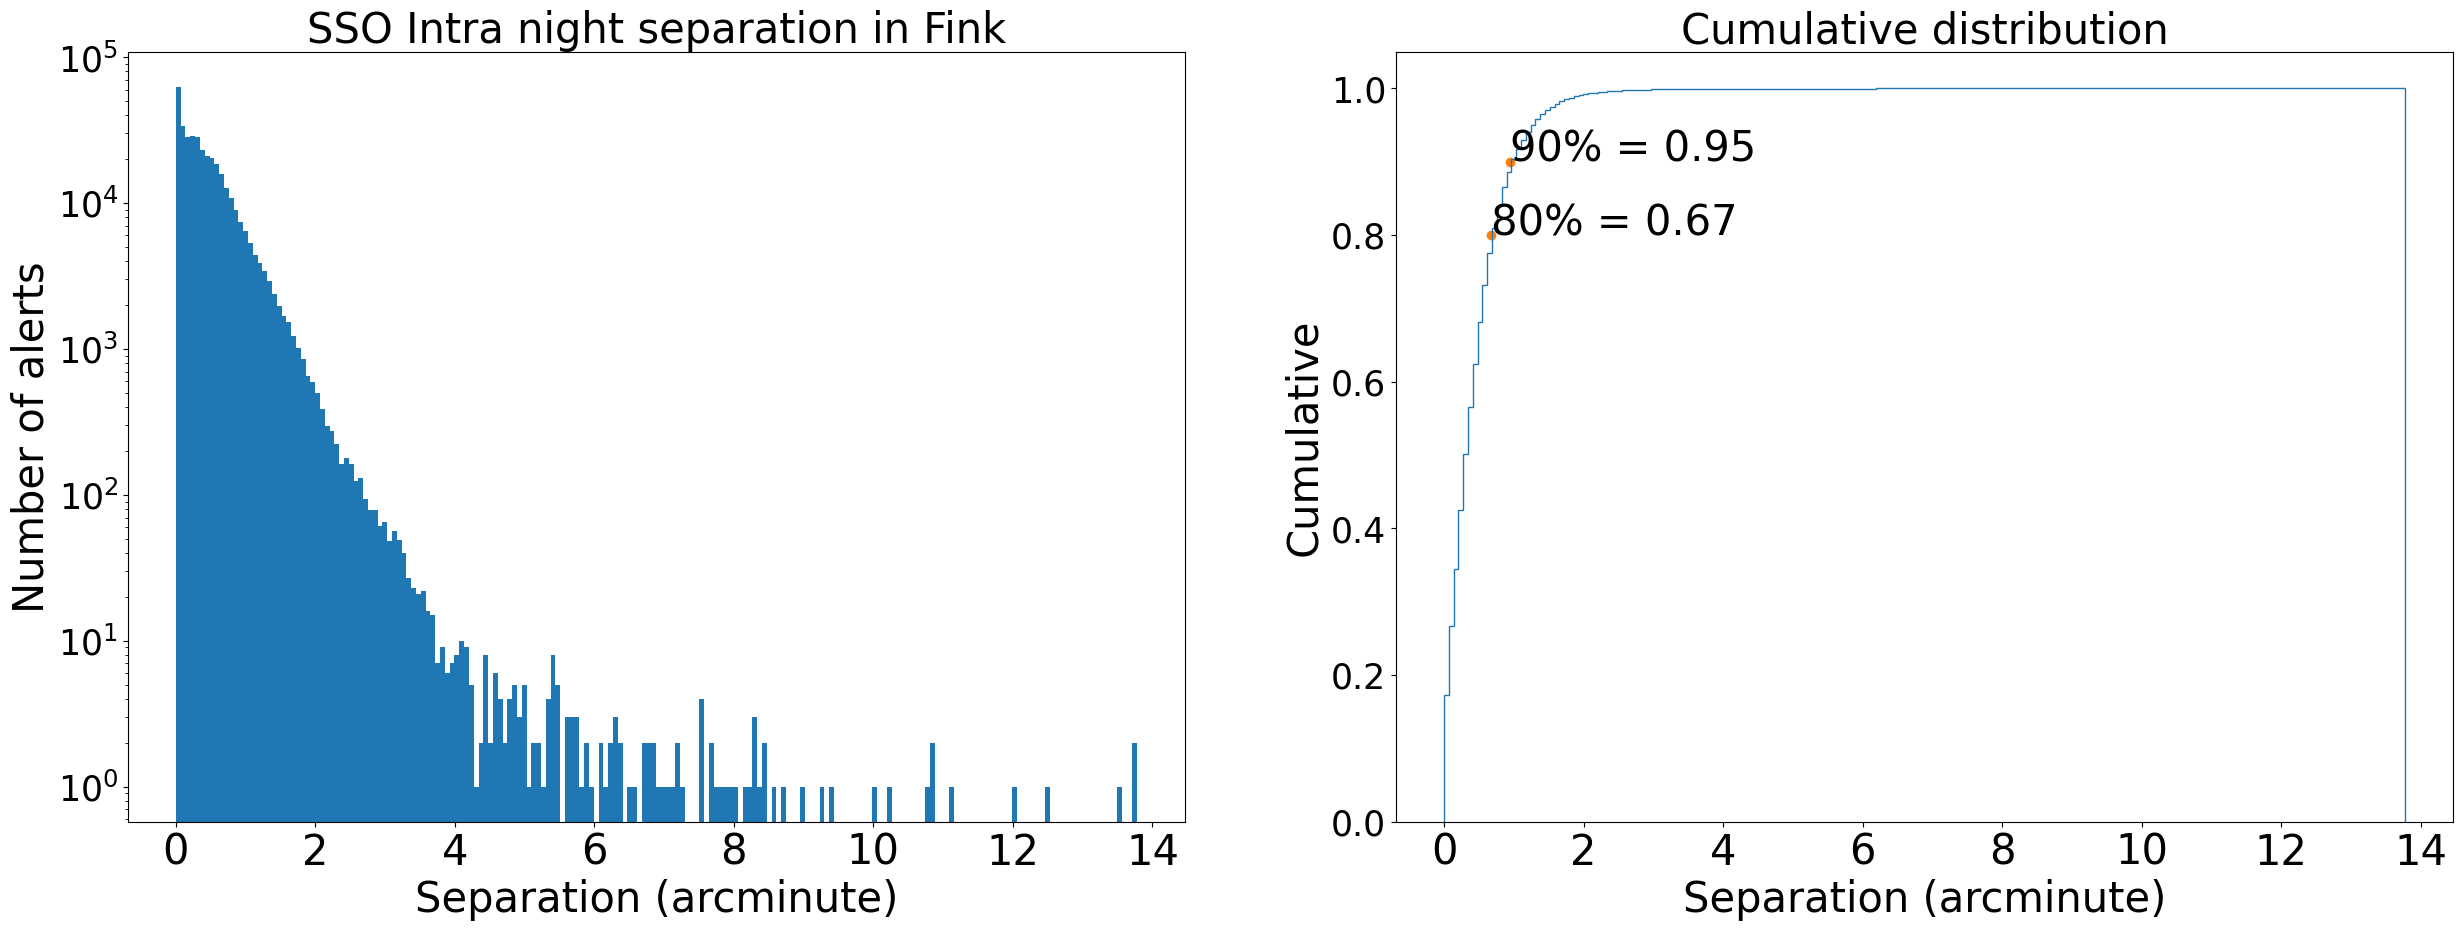

In [61]:
import matplotlib.pyplot as plt
es.plot_hist_and_cdf(speed_intra_sso, None, "SSO Intra night separation in Fink", "Separation (arcminute)", "Number of alerts", None, "Cumulative distribution", "Separation (arcminute)", "Cumulative")